Cell 1 — Imports, root, paths

In [6]:
# 04_model3_forecasting.ipynb
# Goal:
# Predict future P(HIGH) risk for multiple horizons using 5 parameters with classical models.

from pathlib import Path
import os, json, math, warnings, yaml
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (9, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Optional: XGBoost
try:
    from xgboost import XGBRegressor
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# Root finder
def find_project_root(project_name="POSEIDON"):
    cwd = Path.cwd().resolve()
    project_name_l = project_name.lower()
    for p in [cwd] + list(cwd.parents):
        if p.name.lower() == project_name_l:
            return p
    if cwd.name.lower() == "notebooks" and cwd.parent.exists():
        return cwd.parent
    raise FileNotFoundError(f"Could not locate project root '{project_name}'. Starting cwd: {cwd}")

ROOT = find_project_root("Poseidon")

DATA      = ROOT / "data"
INTERIM   = DATA / "interim"
ART       = ROOT / "artifacts"
MODEL_REG = ART  / "model_registry"
FORECASTS = ART  / "forecasts"
REPORTS   = ROOT / "reports"
CONFIGS   = ROOT / "configs"

for d in [FORECASTS, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("Have XGBoost:", HAVE_XGB)


ROOT: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon
Have XGBoost: True


Cell 2 — Load trusted pseudo-labeled Montería & align schema

Trusted dataset shape: (4345, 17)


,timestamp,temperature,pH,turbidity_proxy,predicted_do,predicted_nh3,p_high_teacher,weak_p_high,p_high_cal,risk_argmax,risk_blended,conf_score,high_confidence,proba_HIGH,proba_LOW,proba_MEDIUM,keep_for_training
0,2025-01-01 00:00:00,27.598028,7.937212,0.553292,4.170613,0.029451,0.0,0.625,0.177528,MEDIUM,LOW,0.822472,False,0.0,0.022465,0.977535,True
1,2025-01-01 00:30:00,27.217041,7.872365,0.677565,4.170613,0.028561,0.0,0.625,0.177528,MEDIUM,LOW,0.822472,False,0.0,0.022465,0.977535,True
2,2025-01-01 01:00:00,27.688613,7.941378,0.370436,4.170613,0.030651,0.0,0.500,0.140539,MEDIUM,LOW,0.859461,True,0.0,0.022465,0.977535,True
3,2025-01-01 01:30:00,28.213818,7.804893,0.534500,4.181165,0.030799,0.0,0.500,0.140539,MEDIUM,LOW,0.859461,True,0.0,0.022465,0.977535,True
4,2025-01-01 02:00:00,27.159508,7.822742,0.612958,4.170613,0.023461,0.0,0.625,0.177528,MEDIUM,LOW,0.822472,False,0.0,0.014942,0.985058,True


p_high_target describe():


count    4.345000e+03
mean     1.500000e-01
std      1.861985e-02
min      7.708816e-07
25%      1.405393e-01
50%      1.405393e-01
75%      1.775280e-01
max      4.209612e-01
Name: p_high_target, dtype: float64

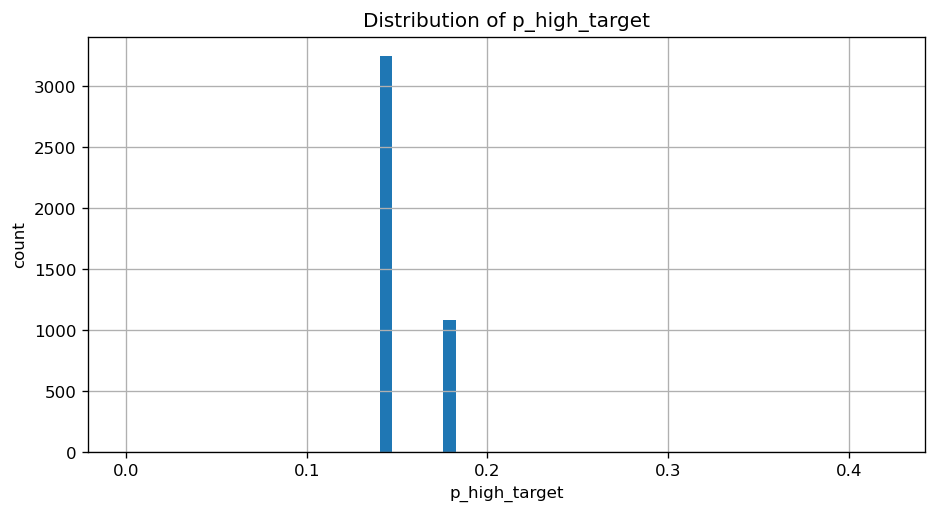

Risk label distribution:


risk_blended
LOW       0.999
MEDIUM    0.001
Name: proportion, dtype: float64

In [7]:
# Load trusted pseudo-labeled dataset from 03.1
p_trust = INTERIM / "monteria_pseudolabeled_trusted.csv"
if not p_trust.exists():
    raise FileNotFoundError(f"Missing trusted data at {p_trust}. Run 03.1_model2_pseudo_labeling.ipynb first.")

df = pd.read_csv(p_trust, parse_dates=["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

print("Trusted dataset shape:", df.shape)
display(df.head(5))

# Required base columns
base_required = [
    "timestamp",
    "temperature","pH","turbidity_proxy",
    "predicted_do","predicted_nh3",
    "risk_blended",
    "p_high_cal"
]
missing_base = [c for c in base_required if c not in df.columns]
if missing_base:
    raise ValueError(f"Trusted dataset missing base columns: {missing_base}")

risk_col = "risk_blended"
df["p_high_target"] = df["p_high_cal"].astype(float)

print("p_high_target describe():")
display(df["p_high_target"].describe())

plt.figure()
df["p_high_target"].hist(bins=60)
plt.title("Distribution of p_high_target")
plt.xlabel("p_high_target"); plt.ylabel("count")
plt.show()

print("Risk label distribution:")
display(df[risk_col].value_counts(normalize=True).round(3))


Cell 3 — Define horizons & sensors

In [8]:
# Approx. 30-minute sampling frequency
HORIZONS = {
    "+1h":  2,
    "+6h":  12,
    "+24h": 48,
    "+3d":  144,
}

SENSORS = ["temperature","pH","turbidity_proxy","predicted_do","predicted_nh3"]

print("Horizons (steps):", HORIZONS)
print("Sensors:", SENSORS)
print("Total rows:", len(df))


Horizons (steps): {'+1h': 2, '+6h': 12, '+24h': 48, '+3d': 144}
Sensors: ['temperature', 'pH', 'turbidity_proxy', 'predicted_do', 'predicted_nh3']
Total rows: 4345


Cell 4 — Feature engineering functions

In [9]:
# HISTORY_STEPS controls how many past steps we include.
# With ~4345 rows, 24 steps (12h window) is fine.
HISTORY_STEPS = 24
ROLL_WINDOWS  = [4, 12, 24]  # 2h, 6h, 12h windows
USE_SLOPE     = True

def add_lag_features(df_in, cols, history_steps):
    df = df_in.copy()
    for c in cols:
        for k in range(1, history_steps+1):
            df[f"{c}_lag{k}"] = df[c].shift(k)
    return df

def add_rolling_features(df_in, cols, windows):
    df = df_in.copy()
    for c in cols:
        s = df[c].astype(float)
        for w in windows:
            df[f"{c}_roll{w}_mean"] = s.rolling(w).mean()
            df[f"{c}_roll{w}_std"]  = s.rolling(w).std()
            df[f"{c}_roll{w}_min"]  = s.rolling(w).min()
            df[f"{c}_roll{w}_max"]  = s.rolling(w).max()
    return df

def add_slope_features(df_in, cols, windows):
    df = df_in.copy()
    for c in cols:
        s = df[c].astype(float)
        for w in windows:
            df[f"{c}_slope{w}"] = (s - s.shift(w)) / w
    return df

def make_features(df_in):
    df = df_in.copy()
    df = add_lag_features(df, SENSORS, HISTORY_STEPS)
    df = add_rolling_features(df, SENSORS, ROLL_WINDOWS)
    if USE_SLOPE:
        df = add_slope_features(df, SENSORS, ROLL_WINDOWS)
    return df


Cell 5 — Build wide feature table + horizon targets

In [10]:
# Start from base columns
base_cols = ["timestamp"] + SENSORS + ["p_high_target", risk_col]
X_all = make_features(df[base_cols])

# Add future targets per horizon
for hname, step in HORIZONS.items():
    X_all[f"y_cont_{hname}"] = df["p_high_target"].shift(-step)
    X_all[f"y_cls_{hname}"]  = df[risk_col].shift(-step)

# Drop rows without full lag history
X_all = X_all.iloc[HISTORY_STEPS:].reset_index(drop=True)

print("Rows in df:", len(df))
print("HISTORY_STEPS:", HISTORY_STEPS)
print("Rows after lag trimming (X_all):", len(X_all))

if len(X_all) < 200:
    raise ValueError(
        f"Only {len(X_all)} rows after lag trimming; not enough for robust forecasting.\n"
        "This would mean either your dataset is too small or HISTORY_STEPS is too large."
    )

print("Wide feature table shape:", X_all.shape)
display(X_all.head(3)[["timestamp","p_high_target","y_cont_+1h","y_cont_+6h"]])


Rows in df: 4345
HISTORY_STEPS: 24
Rows after lag trimming (X_all): 4321
Wide feature table shape: (4321, 211)


,timestamp,p_high_target,y_cont_+1h,y_cont_+6h
0,2025-01-01 12:00:00,0.140539,0.177528,0.140539
1,2025-01-01 12:30:00,0.140539,0.140539,0.140539
2,2025-01-01 13:00:00,0.177528,0.177528,0.140539


Cell 6 — Time-based split (train / val / test)

In [11]:
n = len(X_all)
print("Total rows in X_all:", n)

i_tr = int(0.70 * n)
i_va = int(0.85 * n)

# Ensure non-empty splits
i_tr = max(1, min(i_tr, n-2))
i_va = max(i_tr + 1, min(i_va, n-1))

X_tr = X_all.iloc[:i_tr].copy()
X_va = X_all.iloc[i_tr:i_va].copy()
X_te = X_all.iloc[i_va:].copy()

print("Splits (rows): train =", len(X_tr), "| val =", len(X_va), "| test =", len(X_te))
print("Train:", X_tr["timestamp"].min(), "->", X_tr["timestamp"].max())
print("Val  :", X_va["timestamp"].min(), "->", X_va["timestamp"].max())
print("Test :", X_te["timestamp"].min(), "->", X_te["timestamp"].max())


Total rows in X_all: 4321
Splits (rows): train = 3024 | val = 648 | test = 649
Train: 2025-01-01 12:00:00 -> 2025-03-05 11:30:00
Val  : 2025-03-05 12:00:00 -> 2025-03-18 23:30:00
Test : 2025-03-19 00:00:00 -> 2025-04-01 12:00:00


Cell 7 — Scaling & helper functions

In [12]:
# Cell 7 — Scaling & helper functions (exclude label + only numeric features)

# 1) Define which columns are *not* features
target_cols = [f"y_cont_{h}" for h in HORIZONS] + [f"y_cls_{h}" for h in HORIZONS]

non_feature_cols = ["timestamp", risk_col] + target_cols

# 2) Start from all columns, remove non-feature ones
candidate_feature_cols = [c for c in X_all.columns if c not in non_feature_cols]

# 3) Keep only numeric columns (defensive — avoids any accidental strings)
numeric_cols = list(X_all[candidate_feature_cols].select_dtypes(include=[np.number]).columns)

feature_cols = numeric_cols

print("Risk label column (excluded):", risk_col)
print("Number of candidate feature columns:", len(candidate_feature_cols))
print("Number of numeric feature columns actually used:", len(feature_cols))
print("First 10 feature cols:", feature_cols[:10])

# 4) Fit scaler on TRAIN features only
SCALER = StandardScaler()
SCALER.fit(X_tr[feature_cols].astype(float))

def transform_block(block):
    df_block = block.copy()
    X = df_block[feature_cols].astype(float)
    X_scaled = SCALER.transform(X)
    df_block[feature_cols] = X_scaled
    return df_block

X_tr_s = transform_block(X_tr)
X_va_s = transform_block(X_va)
X_te_s = transform_block(X_te)

# 5) Metrics + plotting helpers
def rmse(a, b): 
    return float(np.sqrt(mean_squared_error(a, b)))

def mae(a, b):  
    return float(mean_absolute_error(a, b))

def plot_pred_vs_true(ts, y_true, y_pred, title):
    plt.figure()
    plt.plot(ts, y_true, label="True", lw=1.5)
    plt.plot(ts, y_pred, label="Pred", lw=1.0)
    plt.title(title)
    plt.xlabel("Time"); plt.ylabel("P(HIGH)")
    plt.legend(); plt.tight_layout(); plt.show()

def plot_residuals_hist(resid, title):
    plt.figure()
    plt.hist(resid, bins=40)
    plt.title(title + " | Residuals")
    plt.xlabel("Error"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()


Risk label column (excluded): risk_blended
Number of candidate feature columns: 201
Number of numeric feature columns actually used: 201
First 10 feature cols: ['temperature', 'pH', 'turbidity_proxy', 'predicted_do', 'predicted_nh3', 'p_high_target', 'temperature_lag1', 'temperature_lag2', 'temperature_lag3', 'temperature_lag4']


Cell 8 — NaN diagnostics & clean-block helper

In [13]:
# NaN diagnostics: how many rows per split/horizon have missing in X or y?
def nan_report_per_horizon(X_tr_s, X_va_s, X_te_s, feature_cols, horizons):
    rep = []
    for hname, _ in horizons.items():
        for split_name, block in [("train", X_tr_s), ("val", X_va_s), ("test", X_te_s)]:
            cols = feature_cols + [f"y_cont_{hname}"]
            sub  = block[cols]
            rep.append({
                "horizon": hname,
                "split": split_name,
                "rows": len(sub),
                "nan_any_rows": int(sub.isna().any(axis=1).sum()),
                "nan_in_y": int(sub[f"y_cont_{hname}"].isna().sum()),
                "nan_in_X_any": int(sub[feature_cols].isna().any(axis=1).sum())
            })
    return pd.DataFrame(rep)

nan_df = nan_report_per_horizon(X_tr_s, X_va_s, X_te_s, feature_cols, HORIZONS)
print("NaN diagnostics:")
display(nan_df)

# Helper: build clean blocks for each horizon
def build_clean_blocks_for_horizon(X_tr_s, X_va_s, X_te_s, feature_cols, horizon_name):
    cols = feature_cols + [f"y_cont_{horizon_name}", "timestamp"]

    def _clean(block):
        sub = block[cols].copy()
        sub = sub.dropna(subset=feature_cols + [f"y_cont_{horizon_name}"])
        X = sub[feature_cols].astype(float).values
        y = sub[f"y_cont_{horizon_name}"].astype(float).values
        ts = sub["timestamp"].values
        return X, y, ts

    Xtr, ytr, ttr = _clean(X_tr_s)
    Xva, yva, tva = _clean(X_va_s)
    Xte, yte, tte = _clean(X_te_s)

    return (Xtr, ytr, ttr), (Xva, yva, tva), (Xte, yte, tte)


NaN diagnostics:


,horizon,split,rows,nan_any_rows,nan_in_y,nan_in_X_any
0,+1h,train,3024,0,0,0
1,+1h,val,648,0,0,0
2,+1h,test,649,2,2,0
3,+6h,train,3024,0,0,0
4,+6h,val,648,0,0,0
5,+6h,test,649,12,12,0
6,+24h,train,3024,0,0,0
7,+24h,val,648,0,0,0
8,+24h,test,649,48,48,0
9,+3d,train,3024,0,0,0


Cell 9 — Classical regressors per horizon (with model selection)

In [14]:
# Cell 9 — Classical regressors per horizon (with proper cloning)

from sklearn.base import clone

REG_CANDIDATES = {
    "ridge": Ridge(alpha=1.0, random_state=0),
    "rf":    RandomForestRegressor(n_estimators=300, random_state=0, n_jobs=-1),
    "extra": ExtraTreesRegressor(n_estimators=400, random_state=0, n_jobs=-1),
    "gbrt":  GradientBoostingRegressor(random_state=0),
    "knn":   KNeighborsRegressor(n_neighbors=15, weights="distance"),
}
if HAVE_XGB:
    REG_CANDIDATES["xgb"] = XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.9,
        random_state=0, tree_method="hist", n_jobs=-1
    )

results = []

for hname, step in HORIZONS.items():
    print(f"\n=== Horizon {hname} ({step} steps) ===")

    (Xtr, ytr, ttr), (Xva, yva, tva), (Xte, yte, tte) = build_clean_blocks_for_horizon(
        X_tr_s, X_va_s, X_te_s, feature_cols, hname
    )

    min_rows = 100
    if len(Xtr) < min_rows or len(Xva) < 30 or len(Xte) < 30:
        print(f"Too few samples after cleaning for {hname}: "
              f"train={len(Xtr)}, val={len(Xva)}, test={len(Xte)}. Skipping.")
        continue

    best_name = None
    best_rmse = np.inf

    for name, base_est in REG_CANDIDATES.items():
        # IMPORTANT: clone the base estimator so we don't overwrite it
        mdl = clone(base_est)
        mdl.fit(Xtr, ytr)
        yva_pred = mdl.predict(Xva)
        val_rmse = rmse(yva, yva_pred)
        print(f"  {name:6s} | Val RMSE={val_rmse:.4f}")
        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_name = name

    print("  -> Winner:", best_name, "| Val RMSE:", round(best_rmse,4))

    results.append({
        "horizon": hname,
        "winner": best_name,
        "val_rmse": float(best_rmse),
        # test metrics will be recomputed in Cell 10
        "test_rmse": np.nan,
        "test_mae": np.nan,
        "model_type": "classical",
    })

res_df = pd.DataFrame(results)
print("\nClassical model summary (validation only):")
display(res_df)



=== Horizon +1h (2 steps) ===
  ridge  | Val RMSE=0.0187
  rf     | Val RMSE=0.0196
  extra  | Val RMSE=0.0185
  gbrt   | Val RMSE=0.0209
  knn    | Val RMSE=0.0186
  xgb    | Val RMSE=0.0188
  -> Winner: extra | Val RMSE: 0.0185

=== Horizon +6h (12 steps) ===
  ridge  | Val RMSE=0.0185
  rf     | Val RMSE=0.0186
  extra  | Val RMSE=0.0182
  gbrt   | Val RMSE=0.0183
  knn    | Val RMSE=0.0188
  xgb    | Val RMSE=0.0185
  -> Winner: extra | Val RMSE: 0.0182

=== Horizon +24h (48 steps) ===
  ridge  | Val RMSE=0.0184
  rf     | Val RMSE=0.0182
  extra  | Val RMSE=0.0181
  gbrt   | Val RMSE=0.0184
  knn    | Val RMSE=0.0186
  xgb    | Val RMSE=0.0186
  -> Winner: extra | Val RMSE: 0.0181

=== Horizon +3d (144 steps) ===
  ridge  | Val RMSE=0.0185
  rf     | Val RMSE=0.0180
  extra  | Val RMSE=0.0180
  gbrt   | Val RMSE=0.0185
  knn    | Val RMSE=0.0187
  xgb    | Val RMSE=0.0184
  -> Winner: extra | Val RMSE: 0.018

Classical model summary (validation only):


,horizon,winner,val_rmse,test_rmse,test_mae,model_type
0,+1h,extra,0.018467,NaN,NaN,classical
1,+6h,extra,0.018187,NaN,NaN,classical
2,+24h,extra,0.018107,NaN,NaN,classical
3,+3d,extra,0.018020,NaN,NaN,classical


Cell 10 — Finalize winners, retrain on train+val, save models + bundle

In [16]:
# Cell 10 — Finalize winners, train per horizon on train+val, save models + bundle

from sklearn.base import clone
import joblib

print("Final winners by horizon (based on validation RMSE):")
best_by_h = res_df.sort_values(["horizon","val_rmse"]).groupby("horizon").head(1).reset_index(drop=True)
display(best_by_h)

FINAL_MODELS = {}

# Helper: build a clean block from a single scaled DataFrame (for train+val or test)
def build_clean_single_block(block_s, feature_cols, horizon_name):
    cols = feature_cols + [f"y_cont_{horizon_name}", "timestamp"]
    sub = block_s[cols].copy()
    sub = sub.dropna(subset=feature_cols + [f"y_cont_{horizon_name}"])
    X = sub[feature_cols].astype(float).values
    y = sub[f"y_cont_{horizon_name}"].astype(float).values
    ts = sub["timestamp"].values
    return X, y, ts

for _, row in best_by_h.iterrows():
    hname   = row["horizon"]
    winname = row["winner"]
    print(f"\n=== Finalizing {hname} ({winname}) ===")

    # Merge TRAIN + VAL
    X_trva_s = pd.concat([X_tr_s, X_va_s], axis=0).reset_index(drop=True)

    # Build cleaned blocks
    Xtrva, ytrva, ttrva = build_clean_single_block(X_trva_s, feature_cols, hname)
    Xte,   yte,   tte   = build_clean_single_block(X_te_s,   feature_cols, hname)

    print("  Train+Val rows:", len(Xtrva), "| Test rows:", len(Xte))
    if len(Xtrva) < 100 or len(Xte) < 30:
        print(f"  WARNING: Few samples for {hname} even after combining train+val. Skipping.")
        continue

    # Clone base estimator and train
    base_est = REG_CANDIDATES[winname]
    mdl = clone(base_est)
    mdl.fit(Xtrva, ytrva)

    # Evaluate on test
    yte_pred = mdl.predict(Xte)
    final_rmse = rmse(yte, yte_pred)
    final_mae  = mae(yte, yte_pred)
    print("  Final Test RMSE:", round(final_rmse,4), "| MAE:", round(final_mae,4))

    FINAL_MODELS[hname] = {
        "name": winname,
        "model": mdl,
        "test_rmse": float(final_rmse),
        "test_mae": float(final_mae),
    }

    # Save this horizon's model
    path = MODEL_REG / f"model3_{hname}_{winname}.joblib"
    joblib.dump(mdl, path)
    print("  Saved model:", path)

# Bundle (shared config + per-horizon metrics; models themselves saved separately)
bundle = {
    "feature_cols": feature_cols,
    "sensors": SENSORS,
    "history_steps": HISTORY_STEPS,
    "roll_windows": ROLL_WINDOWS,
    "use_slope": USE_SLOPE,
    "horizons": HORIZONS,
    "models_meta": {
        h: {
            "name": v["name"],
            "test_rmse": v["test_rmse"],
            "test_mae": v["test_mae"],
        }
        for h, v in FINAL_MODELS.items()
    },
    "scaler": SCALER,
    "risk_label_column": risk_col,
}
bundle_path = MODEL_REG / "model3_forecast_bundle.joblib"
joblib.dump(bundle, bundle_path)
print("\nSaved forecast bundle:", bundle_path)


Final winners by horizon (based on validation RMSE):


,horizon,winner,val_rmse,test_rmse,test_mae,model_type
0,+1h,extra,0.018467,NaN,NaN,classical
1,+24h,extra,0.018107,NaN,NaN,classical
2,+3d,extra,0.018020,NaN,NaN,classical
3,+6h,extra,0.018187,NaN,NaN,classical



=== Finalizing +1h (extra) ===
  Train+Val rows: 3672 | Test rows: 647
  Final Test RMSE: 0.0171 | MAE: 0.0145
  Saved model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_+1h_extra.joblib

=== Finalizing +24h (extra) ===
  Train+Val rows: 3672 | Test rows: 601
  Final Test RMSE: 0.0169 | MAE: 0.0144
  Saved model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_+24h_extra.joblib

=== Finalizing +3d (extra) ===
  Train+Val rows: 3672 | Test rows: 505
  Final Test RMSE: 0.0172 | MAE: 0.0143
  Saved model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_+3d_extra.joblib

=== Finalizing +6h (extra) ===
  Train+Val rows: 3672 | Test rows: 637
  Final Test RMSE: 0.0171 | MAE: 0.0146
  Saved model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_+6h_extra.joblib

Saved forecast bundle: C:\Users\P

Cell 11 — Summary CSV + example test forecasts

In [17]:
# Cell 11 — Summary CSV + per-horizon test forecasts (no length mismatch)

# Summary table
summary_rows = []
for h, obj in FINAL_MODELS.items():
    summary_rows.append({
        "horizon": h,
        "model_name": obj["name"],
        "test_rmse": obj["test_rmse"],
        "test_mae": obj["test_mae"],
    })
summary = pd.DataFrame(summary_rows).sort_values("horizon")
print("Forecasting summary:")
display(summary)

summary_path = REPORTS / "model3_forecast_summary.csv"
summary.to_csv(summary_path, index=False)
print("Saved summary to:", summary_path)

# --- Per-horizon forecast exports ---

from functools import reduce

forecast_frames = []  # we'll collect per-horizon frames if you want a merged view at the end

for h, obj in FINAL_MODELS.items():
    print(f"\nBuilding test forecasts for horizon {h} ...")
    # Clean test block for this horizon
    (_, _, _), (_, _, _), (Xte, yte, tte) = build_clean_blocks_for_horizon(
        X_tr_s, X_va_s, X_te_s, feature_cols, h
    )

    # Predict
    y_pred = obj["model"].predict(Xte)

    # Build a per-horizon DataFrame using that horizon's own timestamps
    df_h = pd.DataFrame({
        "timestamp": pd.to_datetime(tte),
        f"true_{h}": yte,
        f"pred_{h}": y_pred,
    })

    # Save individual horizon forecast
    out_h = FORECASTS / f"model3_test_forecasts_{h}.csv"
    df_h.to_csv(out_h, index=False)
    print("  Saved:", out_h)

    forecast_frames.append(df_h)

# Optionally merge all horizons on timestamp (outer join)
if forecast_frames:
    merged = reduce(lambda left, right: pd.merge(left, right, on="timestamp", how="outer"),
                    forecast_frames)
    merged_path = FORECASTS / "model3_test_forecasts_all_horizons.csv"
    merged.to_csv(merged_path, index=False)
    print("\nSaved merged forecasts for all horizons to:", merged_path)
    display(merged.head())
else:
    print("No horizons produced forecasts (FINAL_MODELS is empty).")


Forecasting summary:


,horizon,model_name,test_rmse,test_mae
0,+1h,extra,0.017136,0.014545
1,+24h,extra,0.016879,0.014413
2,+3d,extra,0.017158,0.014311
3,+6h,extra,0.017120,0.014605


Saved summary to: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\reports\model3_forecast_summary.csv

Building test forecasts for horizon +1h ...
  Saved: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\forecasts\model3_test_forecasts_+1h.csv

Building test forecasts for horizon +24h ...
  Saved: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\forecasts\model3_test_forecasts_+24h.csv

Building test forecasts for horizon +3d ...
  Saved: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\forecasts\model3_test_forecasts_+3d.csv

Building test forecasts for horizon +6h ...
  Saved: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\forecasts\model3_test_forecasts_+6h.csv

Saved merged forecasts for all horizons to: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\forecasts\model3_test_forecasts_all_horizons.csv


,timestamp,true_+1h,pred_+1h,true_+24h,pred_+24h,true_+3d,pred_+3d,true_+6h,pred_+6h
0,2025-03-19 00:00:00,0.140539,0.150452,0.140539,0.148492,0.140539,0.150859,0.140539,0.152048
1,2025-03-19 00:30:00,0.140539,0.152237,0.177528,0.149879,0.140539,0.149377,0.140539,0.148498
2,2025-03-19 01:00:00,0.140539,0.152325,0.140539,0.149417,0.140539,0.149047,0.140539,0.149601
3,2025-03-19 01:30:00,0.140539,0.151919,0.177528,0.145995,0.177528,0.148307,0.177528,0.147752
4,2025-03-19 02:00:00,0.140539,0.151068,0.140539,0.147567,0.140539,0.147475,0.177528,0.150078


New Cell 12 — Import Keras & compute split boundaries

In [18]:
# Cell 12 — Deep learning setup (Keras + time boundaries from classical split)

# Try importing TensorFlow / Keras
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, callbacks, optimizers
    HAVE_TF = True
except Exception as e:
    HAVE_TF = False
    print("ERROR: TensorFlow/Keras not available. Install tensorflow before running deep models.")
    print("You can still run the classical models without this section.")
    raise e

print("TensorFlow version:", tf.__version__)

# We will reuse the same df, SENSORS, HORIZONS, HISTORY_STEPS, and the train/val/test boundaries.

# Get time boundaries from your classical split (X_tr, X_va, X_te)
TR_END = X_tr["timestamp"].max()
VA_END = X_va["timestamp"].max()
TE_START = X_te["timestamp"].min()

print("Time boundaries for sequences:")
print("Train end   :", TR_END)
print("Val end     :", VA_END)
print("Test start  :", TE_START)


TensorFlow version: 2.20.0
Time boundaries for sequences:
Train end   : 2025-03-05 11:30:00
Val end     : 2025-03-18 23:30:00
Test start  : 2025-03-19 00:00:00


New Cell 13 — Build sequence datasets per horizon

In [19]:
# Cell 13 — Sequence dataset builder for deep models

from sklearn.preprocessing import StandardScaler

# 1) Fit a scaler on the 5 sensors using only TRAIN period
sensor_df = df.copy().sort_values("timestamp").reset_index(drop=True)

# Identify which rows are train/val/test based on timestamp
is_train = sensor_df["timestamp"] <= TR_END
is_val   = (sensor_df["timestamp"] > TR_END) & (sensor_df["timestamp"] <= VA_END)
is_test  = sensor_df["timestamp"] > VA_END

SENSORS_SCALER = StandardScaler()
SENSORS_SCALER.fit(sensor_df.loc[is_train, SENSORS].astype(float))

sensor_df[SENSORS] = SENSORS_SCALER.transform(sensor_df[SENSORS].astype(float))

print("Sensor scaler fitted on TRAIN subset.")
print(sensor_df[SENSORS].describe().round(3))


def build_sequence_dataset_for_horizon(df_in, sensors_cols, target_col, history_steps, horizon_steps):
    """
    df_in: sorted by timestamp, contains sensors_cols + target_col
    Returns:
        (X_tr, y_tr), (X_va, y_va), (X_te, y_te)
    where X_* shape = (n_samples, history_steps, len(sensors_cols))
          y_* shape = (n_samples,)
    """
    df_sorted = df_in.sort_values("timestamp").reset_index(drop=True)
    values = df_sorted[sensors_cols].values.astype(float)
    target = df_sorted[target_col].values.astype(float)
    timestamps = df_sorted["timestamp"].values

    X_seq = []
    y_seq = []
    t_seq = []

    max_i = len(df_sorted) - horizon_steps  # ensure we have future target
    for i in range(history_steps, max_i):
        # sequence: [i-history_steps, ..., i-1]
        seq = values[i-history_steps:i, :]
        y   = target[i + horizon_steps]   # future horizon
        t   = timestamps[i]               # we anchor sequence at "current" time

        if np.isnan(seq).any() or np.isnan(y):
            continue

        X_seq.append(seq)
        y_seq.append(y)
        t_seq.append(t)

    X_seq = np.array(X_seq, dtype=np.float32)
    y_seq = np.array(y_seq, dtype=np.float32)
    t_seq = np.array(t_seq)

    # Split by timestamp boundaries TR_END / VA_END
    is_tr_seq = t_seq <= TR_END
    is_va_seq = (t_seq > TR_END) & (t_seq <= VA_END)
    is_te_seq = t_seq > VA_END

    X_tr = X_seq[is_tr_seq]
    y_tr = y_seq[is_tr_seq]
    X_va = X_seq[is_va_seq]
    y_va = y_seq[is_va_seq]
    X_te = X_seq[is_te_seq]
    y_te = y_seq[is_te_seq]

    print(f"Horizon step={horizon_steps} | total seq={len(X_seq)}, "
          f"train={len(X_tr)}, val={len(X_va)}, test={len(X_te)}")

    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te)


# Build datasets per horizon
seq_datasets = {}  # hname -> {"train":(X_tr,y_tr), "val":(...), "test":(...)}

for hname, step in HORIZONS.items():
    print(f"\n=== Building sequences for horizon {hname} ({step} steps) ===")
    (X_tr_seq, y_tr_seq), (X_va_seq, y_va_seq), (X_te_seq, y_te_seq) = build_sequence_dataset_for_horizon(
        sensor_df, SENSORS, "p_high_target", HISTORY_STEPS, step
    )
    seq_datasets[hname] = {
        "train": (X_tr_seq, y_tr_seq),
        "val":   (X_va_seq, y_va_seq),
        "test":  (X_te_seq, y_te_seq),
    }

print("\nSequence datasets ready.")


Sensor scaler fitted on TRAIN subset.
       temperature        pH  turbidity_proxy  predicted_do  predicted_nh3
count     4345.000  4345.000         4345.000      4345.000       4345.000
mean        -0.017     0.000            0.003        -0.019         -0.018
std          1.010     1.004            0.993         0.994          0.945
min         -3.308    -4.019           -3.604        -3.536         -2.304
25%         -0.689    -0.666           -0.671        -0.737         -0.559
50%         -0.015    -0.001            0.005         0.406         -0.163
75%          0.647     0.669            0.676         0.406          0.438
max          3.946     3.483            4.377         8.347         25.227

=== Building sequences for horizon +1h (2 steps) ===
Horizon step=2 | total seq=4319, train=3024, val=648, test=647

=== Building sequences for horizon +6h (12 steps) ===
Horizon step=12 | total seq=4309, train=3024, val=648, test=637

=== Building sequences for horizon +24h (48 steps)

New Cell 14 — Define LSTM, GRU, and 1D-CNN builders

In [20]:
# Cell 14 — Deep model builders (LSTM, GRU, CNN)

def build_lstm_model(input_shape):
    """
    input_shape: (timesteps, n_features)
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=0.0),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # output in [0,1]
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


def build_gru_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.GRU(32),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


def build_cnn1d_model(input_shape):
    """
    1D CNN over time dimension.
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(64, kernel_size=3, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=["mae"]
    )
    return model


New Cell 15 — Training loop for deep models per horizon

In [21]:
# Cell 15 — Train deep models (LSTM/GRU/CNN) per horizon

import math

def rmse_np(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
def mae_np(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

MAX_EPOCHS = 50
BATCH_SIZE = 64
PATIENCE   = 5

deep_results = []       # rows: {horizon, model_type, test_rmse, test_mae, val_rmse, best_epoch}
DEEP_MODELS  = {}       # nested dict: DEEP_MODELS[hname][arch] = model

for hname, step in HORIZONS.items():
    print(f"\n================ Deep models for horizon {hname} ({step} steps) ================")

    ds = seq_datasets[hname]
    X_tr_seq, y_tr_seq = ds["train"]
    X_va_seq, y_va_seq = ds["val"]
    X_te_seq, y_te_seq = ds["test"]

    print("Train seq:", X_tr_seq.shape, "| Val seq:", X_va_seq.shape, "| Test seq:", X_te_seq.shape)

    # Require a minimum amount of data
    if len(X_tr_seq) < 200 or len(X_va_seq) < 50 or len(X_te_seq) < 50:
        print("Not enough sequence data for deep models on this horizon. Skipping.")
        continue

    input_shape = X_tr_seq.shape[1:]  # (timesteps, features)

    # Prepare architectures
    arch_builders = {
        "lstm": build_lstm_model,
        "gru":  build_gru_model,
        "cnn":  build_cnn1d_model,
    }

    DEEP_MODELS[hname] = {}

    for arch_name, builder in arch_builders.items():
        print(f"\n--- Training {arch_name.upper()} for horizon {hname} ---")
        model = builder(input_shape)
        model.summary(print_fn=lambda x: print("   " + x))

        es = callbacks.EarlyStopping(
            monitor="val_loss",
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        )

        history = model.fit(
            X_tr_seq, y_tr_seq,
            validation_data=(X_va_seq, y_va_seq),
            epochs=MAX_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[es],
            verbose=1
        )

        # Best epoch is len(history.history["loss"]) - patience_offset, but
        # simpler: get min val_loss epoch
        val_losses = history.history["val_loss"]
        best_epoch = int(np.argmin(val_losses)) + 1
        best_val_rmse = math.sqrt(val_losses[best_epoch-1])

        # Evaluate on test
        y_pred_te = model.predict(X_te_seq).reshape(-1)
        test_rmse = rmse_np(y_te_seq, y_pred_te)
        test_mae  = mae_np(y_te_seq, y_pred_te)

        print(f"{arch_name.upper()} | Best epoch: {best_epoch} | Val RMSE ~ {best_val_rmse:.4f}")
        print(f"{arch_name.upper()} | Test RMSE: {test_rmse:.4f} | Test MAE: {test_mae:.4f}")

        deep_results.append({
            "horizon": hname,
            "model_type": arch_name,
            "val_rmse": float(best_val_rmse),
            "test_rmse": float(test_rmse),
            "test_mae": float(test_mae),
            "best_epoch": int(best_epoch),
        })

        # Save model
        save_path = MODEL_REG / f"model3_deep_{hname}_{arch_name}.h5"
        model.save(save_path)
        print("Saved deep model:", save_path)

        DEEP_MODELS[hname][arch_name] = model

print("\nDeep models training complete.")
deep_results_df = pd.DataFrame(deep_results)
display(deep_results_df.sort_values(["horizon","test_rmse"]))



================ Deep models for horizon +1h (2 steps) ================
Train seq: (3024, 24, 5) | Val seq: (648, 24, 5) | Test seq: (647, 24, 5)

--- Training LSTM for horizon +1h ---


   Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼──────────────────

LSTM | Best epoch: 6 | Val RMSE ~ 0.0183
LSTM | Test RMSE: 0.0167 | Test MAE: 0.0144
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+1h_lstm.h5

--- Training GRU for horizon +1h ---


   Model: "sequential_1"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────

GRU | Best epoch: 11 | Val RMSE ~ 0.0187
GRU | Test RMSE: 0.0174 | Test MAE: 0.0158
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+1h_gru.h5

--- Training CNN for horizon +1h ---


   Model: "sequential_2"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                

CNN | Best epoch: 32 | Val RMSE ~ 0.0182
CNN | Test RMSE: 0.0170 | Test MAE: 0.0149
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+1h_cnn.h5

================ Deep models for horizon +6h (12 steps) ================
Train seq: (3024, 24, 5) | Val seq: (648, 24, 5) | Test seq: (637, 24, 5)

--- Training LSTM for horizon +6h ---


   Model: "sequential_3"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────

LSTM | Best epoch: 6 | Val RMSE ~ 0.0181
LSTM | Test RMSE: 0.0168 | Test MAE: 0.0140
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+6h_lstm.h5

--- Training GRU for horizon +6h ---


   Model: "sequential_4"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────

GRU | Best epoch: 10 | Val RMSE ~ 0.0186
GRU | Test RMSE: 0.0178 | Test MAE: 0.0149
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+6h_gru.h5

--- Training CNN for horizon +6h ---


   Model: "sequential_5"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 24, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 24, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                

CNN | Best epoch: 4 | Val RMSE ~ 0.0254
CNN | Test RMSE: 0.0267 | Test MAE: 0.0218
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+6h_cnn.h5

================ Deep models for horizon +24h (48 steps) ================
Train seq: (3024, 24, 5) | Val seq: (648, 24, 5) | Test seq: (601, 24, 5)

--- Training LSTM for horizon +24h ---


   Model: "sequential_6"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────

LSTM | Best epoch: 5 | Val RMSE ~ 0.0178
LSTM | Test RMSE: 0.0168 | Test MAE: 0.0133
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+24h_lstm.h5

--- Training GRU for horizon +24h ---


   Model: "sequential_7"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 24, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────

GRU | Best epoch: 11 | Val RMSE ~ 0.0181
GRU | Test RMSE: 0.0179 | Test MAE: 0.0150
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+24h_gru.h5

--- Training CNN for horizon +24h ---


   Model: "sequential_8"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 24, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 24, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                

CNN | Best epoch: 5 | Val RMSE ~ 0.0266
CNN | Test RMSE: 0.0265 | Test MAE: 0.0226
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+24h_cnn.h5

================ Deep models for horizon +3d (144 steps) ================
Train seq: (3024, 24, 5) | Val seq: (648, 24, 5) | Test seq: (505, 24, 5)

--- Training LSTM for horizon +3d ---


   Model: "sequential_9"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 24, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 24, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────

LSTM | Best epoch: 4 | Val RMSE ~ 0.0179
LSTM | Test RMSE: 0.0170 | Test MAE: 0.0141
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+3d_lstm.h5

--- Training GRU for horizon +3d ---


   Model: "sequential_10"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 24, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼───────────────

GRU | Best epoch: 14 | Val RMSE ~ 0.0182
GRU | Test RMSE: 0.0173 | Test MAE: 0.0145
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+3d_gru.h5

--- Training CNN for horizon +3d ---


   Model: "sequential_11"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 24, 32)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 24, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │               

CNN | Best epoch: 12 | Val RMSE ~ 0.0235
CNN | Test RMSE: 0.0245 | Test MAE: 0.0218
Saved deep model: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_deep_+3d_cnn.h5

Deep models training complete.


,horizon,model_type,val_rmse,test_rmse,test_mae,best_epoch
0,+1h,lstm,0.018301,0.016739,0.014402,6
2,+1h,cnn,0.018167,0.016998,0.014945,32
1,+1h,gru,0.018676,0.017427,0.015761,11
6,+24h,lstm,0.017786,0.016771,0.013262,5
7,+24h,gru,0.018120,0.017862,0.014983,11
8,+24h,cnn,0.026600,0.026524,0.022587,5
9,+3d,lstm,0.017920,0.016966,0.014126,4
10,+3d,gru,0.018159,0.017259,0.014537,14
11,+3d,cnn,0.023479,0.024530,0.021797,12
3,+6h,lstm,0.018141,0.016758,0.013992,6


New Cell 16 — Compare classical vs deep models

In [22]:
# Cell 16 — Classical vs Deep: comparison table

# classical summary: best_by_h or res_df/best_by_h from earlier
# We already had `best_by_h` and `summary` (classical).
# Let's reconstruct a simple classical summary from FINAL_MODELS:

classical_summary_rows = []
for h, obj in FINAL_MODELS.items():
    classical_summary_rows.append({
        "horizon": h,
        "model_family": "classical_" + obj["name"],
        "test_rmse": obj["test_rmse"],
        "test_mae": obj["test_mae"],
    })
classical_summary_df = pd.DataFrame(classical_summary_rows)

print("Classical models:")
display(classical_summary_df.sort_values("horizon"))

print("Deep models:")
display(deep_results_df.sort_values(["horizon","test_rmse"]))

# Merge on horizon for high-level comparison (best deep per horizon)
best_deep_by_h = (deep_results_df.sort_values(["horizon","test_rmse"])
                  .groupby("horizon").head(1)
                  .rename(columns={"model_type":"deep_model_type",
                                   "test_rmse":"deep_test_rmse",
                                   "test_mae":"deep_test_mae"}))

cmp = pd.merge(
    classical_summary_df,
    best_deep_by_h[["horizon","deep_model_type","deep_test_rmse","deep_test_mae"]],
    on="horizon",
    how="left"
)

print("Classical vs best Deep per horizon:")
display(cmp.sort_values("horizon"))


Classical models:


,horizon,model_family,test_rmse,test_mae
0,+1h,classical_extra,0.017136,0.014545
1,+24h,classical_extra,0.016879,0.014413
2,+3d,classical_extra,0.017158,0.014311
3,+6h,classical_extra,0.017120,0.014605


Deep models:


,horizon,model_type,val_rmse,test_rmse,test_mae,best_epoch
0,+1h,lstm,0.018301,0.016739,0.014402,6
2,+1h,cnn,0.018167,0.016998,0.014945,32
1,+1h,gru,0.018676,0.017427,0.015761,11
6,+24h,lstm,0.017786,0.016771,0.013262,5
7,+24h,gru,0.018120,0.017862,0.014983,11
8,+24h,cnn,0.026600,0.026524,0.022587,5
9,+3d,lstm,0.017920,0.016966,0.014126,4
10,+3d,gru,0.018159,0.017259,0.014537,14
11,+3d,cnn,0.023479,0.024530,0.021797,12
3,+6h,lstm,0.018141,0.016758,0.013992,6


Classical vs best Deep per horizon:


,horizon,model_family,test_rmse,test_mae,deep_model_type,deep_test_rmse,deep_test_mae
0,+1h,classical_extra,0.017136,0.014545,lstm,0.016739,0.014402
1,+24h,classical_extra,0.016879,0.014413,lstm,0.016771,0.013262
2,+3d,classical_extra,0.017158,0.014311,lstm,0.016966,0.014126
3,+6h,classical_extra,0.017120,0.014605,lstm,0.016758,0.013992


Hybrid Finalization Cell (Choose hybrid models)

In [23]:
# Cell 17 — Hybrid finalization: choose best (classical vs deep) per horizon and save bundle

from pathlib import Path
import joblib

# Safety checks
assert "FINAL_MODELS" in globals(), "FINAL_MODELS (classical) not found — run classical cells first."
assert "deep_results_df" in globals(), "deep_results_df not found — run deep training cells first."

print("Finalizing hybrid forecast models (classical vs deep)...\n")

HYBRID_MODELS = []  # list of rows for a summary table
HYBRID_META   = {}  # for saving in the bundle, keyed by horizon

# We'll use a small margin so that tiny differences don't flip decisions.
# If deep is only microscopically better (< margin), we can still prefer classical for simplicity.
RMSE_MARGIN = 0.0002  # tweak if desired

for h in sorted(HORIZONS.keys()):
    print(f"=== Horizon {h} ===")

    # ---- Classical info ----
    classical = FINAL_MODELS.get(h)
    if classical is None:
        print(f"  No classical model registered for {h}, skipping.")
        continue

    cls_rmse = classical["test_rmse"]
    cls_mae  = classical["test_mae"]
    cls_name = classical["name"]
    # We assume classical models were already saved as:
    # MODEL_REG / f"model3_{h}_{cls_name}.joblib"
    cls_path = MODEL_REG / f"model3_{h}_{cls_name}.joblib"

    # ---- Deep info ----
    deep_rows = deep_results_df[deep_results_df["horizon"] == h]
    has_deep = len(deep_rows) > 0

    chosen_family = "classical"
    chosen_algo   = cls_name
    chosen_rmse   = cls_rmse
    chosen_mae    = cls_mae
    chosen_path   = str(cls_path)
    chosen_arch   = None

    if has_deep:
        best_deep = (deep_rows.sort_values("test_rmse").iloc[0]).to_dict()
        dp_rmse = best_deep["test_rmse"]
        dp_mae  = best_deep["test_mae"]
        dp_arch = best_deep["model_type"]  # "lstm", "gru", or "cnn"

        print(f"  Classical: {cls_name:>10s} | RMSE={cls_rmse:.6f} | MAE={cls_mae:.6f}")
        print(f"  Best Deep: {dp_arch:>10s} | RMSE={dp_rmse:.6f} | MAE={dp_mae:.6f}")

        # Decide which to keep
        if dp_rmse + RMSE_MARGIN < cls_rmse:
            # Deep meaningfully better → choose deep
            chosen_family = "deep"
            chosen_algo   = dp_arch
            chosen_rmse   = dp_rmse
            chosen_mae    = dp_mae
            chosen_arch   = dp_arch

            # Deep models were saved in Cell 15 as:
            # MODEL_REG / f"model3_deep_{h}_{arch_name}.h5"
            deep_path = MODEL_REG / f"model3_deep_{h}_{dp_arch}.h5"
            chosen_path = str(deep_path)

            print(f"  -> Choosing DEEP ({dp_arch}) for {h}")
        else:
            # Classical still competitive / simpler
            print(f"  -> Keeping CLASSICAL ({cls_name}) for {h}")
    else:
        print(f"  No deep models for {h}. Using classical ({cls_name}).")

    HYBRID_MODELS.append({
        "horizon": h,
        "chosen_family": chosen_family,    # "classical" or "deep"
        "chosen_algo": chosen_algo,        # e.g. "extra", "lstm"
        "test_rmse": chosen_rmse,
        "test_mae": chosen_mae,
        "model_path": chosen_path,
    })

    HYBRID_META[h] = {
        "family": chosen_family,
        "algo": chosen_algo,
        "test_rmse": chosen_rmse,
        "test_mae": chosen_mae,
        "model_path": chosen_path,
    }

# Turn into a DataFrame for inspection
hybrid_df = pd.DataFrame(HYBRID_MODELS).sort_values("horizon")
print("\nHybrid horizon selection (classical vs deep):")
display(hybrid_df)

# ---- Save hybrid bundle ----
# We store:
#   - tabular feature columns & scaler (for classical)
#   - sensors & sensors scaler (for deep sequence models)
#   - horizons, history steps, roll windows, etc.
#   - which model family/arch is used per horizon and where it's saved.

hybrid_bundle = {
    "feature_cols": feature_cols,          # used by classical models
    "sensors": SENSORS,                    # raw sensor names
    "history_steps": HISTORY_STEPS,        # for sequence models
    "roll_windows": ROLL_WINDOWS,
    "use_slope": USE_SLOPE,
    "horizons": HORIZONS,
    "risk_label_column": risk_col,         # e.g. "risk_blended" or similar
    "scaler_tabular": SCALER,              # StandardScaler for tabular features
    "scaler_sensors": SENSORS_SCALER,      # StandardScaler for sensor sequences
    "hybrid_models": HYBRID_META,          # per-horizon metadata
}

hybrid_bundle_path = MODEL_REG / "model3_forecast_hybrid_bundle.joblib"
joblib.dump(hybrid_bundle, hybrid_bundle_path)
print("\nSaved hybrid forecast bundle to:", hybrid_bundle_path)


Finalizing hybrid forecast models (classical vs deep)...

=== Horizon +1h ===
  Classical:      extra | RMSE=0.017136 | MAE=0.014545
  Best Deep:       lstm | RMSE=0.016739 | MAE=0.014402
  -> Choosing DEEP (lstm) for +1h
=== Horizon +24h ===
  Classical:      extra | RMSE=0.016879 | MAE=0.014413
  Best Deep:       lstm | RMSE=0.016771 | MAE=0.013262
  -> Keeping CLASSICAL (extra) for +24h
=== Horizon +3d ===
  Classical:      extra | RMSE=0.017158 | MAE=0.014311
  Best Deep:       lstm | RMSE=0.016966 | MAE=0.014126
  -> Keeping CLASSICAL (extra) for +3d
=== Horizon +6h ===
  Classical:      extra | RMSE=0.017120 | MAE=0.014605
  Best Deep:       lstm | RMSE=0.016758 | MAE=0.013992
  -> Choosing DEEP (lstm) for +6h

Hybrid horizon selection (classical vs deep):


,horizon,chosen_family,chosen_algo,test_rmse,test_mae,model_path
0,+1h,deep,lstm,0.016739,0.014402,C:\Users\PC\Documents\Machine_Learning\Capston...
1,+24h,classical,extra,0.016879,0.014413,C:\Users\PC\Documents\Machine_Learning\Capston...
2,+3d,classical,extra,0.017158,0.014311,C:\Users\PC\Documents\Machine_Learning\Capston...
3,+6h,deep,lstm,0.016758,0.013992,C:\Users\PC\Documents\Machine_Learning\Capston...



Saved hybrid forecast bundle to: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\artifacts\model_registry\model3_forecast_hybrid_bundle.joblib


In [24]:
from pathlib import Path
import sys

# Ensure repo root is on sys.path so 'src' can be imported from notebooks/
# If your notebook is under the repo's 'notebooks/' folder this goes up one level.
nb_cwd = Path.cwd()
repo_root = nb_cwd
if not (repo_root / "src").exists():
    repo_root = nb_cwd.parent  # move up if notebook CWD is notebooks/
sys.path.insert(0, str(repo_root.resolve()))
print("Added to sys.path:\", sys.path[0]")

Added to sys.path:", sys.path[0]


In [25]:
from src.runtime_forecast import predict_future_risk

# Build a test input using the last HISTORY_STEPS rows
# from the trusted Montería dataset (df)
recent_df = df.sort_values("timestamp").tail(HISTORY_STEPS)[
    ["timestamp", "temperature", "pH", "turbidity_proxy", "predicted_do", "predicted_nh3"]
].copy()

print("Recent_df shape:", recent_df.shape)
display(recent_df.tail(3))

preds = predict_future_risk(recent_df)
print("\nHybrid forecast output:")
print(preds)

Recent_df shape: (24, 6)


,timestamp,temperature,pH,turbidity_proxy,predicted_do,predicted_nh3
4342,2025-04-01 11:00:00,28.469006,7.864931,0.281528,4.181165,0.033821
4343,2025-04-01 11:30:00,27.915065,8.089603,0.554239,4.170613,0.026999
4344,2025-04-01 12:00:00,26.907661,8.264689,0.434256,3.902854,0.011125


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step

Hybrid forecast output:
{'+1h': 0.15413106977939606, '+24h': 0.14396072529619838, '+3d': 0.1447929705835469, '+6h': 0.14368331020041553}


New Cell 17 — Plot deep vs true for a sample horizon

In [ ]:
# Cell 17 — Visual check: deep vs true for one horizon (e.g. +6h)

hname_plot = "+6h"  # change to "+1h", "+24h", "+3d" as needed
arch_plot  = "lstm" # or "gru", "cnn"

if hname_plot in seq_datasets and hname_plot in DEEP_MODELS and arch_plot in DEEP_MODELS[hname_plot]:
    ds = seq_datasets[hname_plot]
    X_te_seq, y_te_seq = ds["test"]
    model = DEEP_MODELS[hname_plot][arch_plot]

    y_pred_te = model.predict(X_te_seq).reshape(-1)

    # Build a timestamp vector for test sequences (center times)
    df_sorted = sensor_df.sort_values("timestamp").reset_index(drop=True)
    # We re-derive the timestamps used for test in the builder, but simpler:
    # If needed we re-run the builder for this horizon to recover t_seq:
    _, _, (Xte_dummy, yte_dummy) = None, None, None  # placeholder

    # Instead, let's quickly re-run building to recover timestamps:
    (_, _), (_, _), (_, _,)  # no-op to remember structure
else:
    print(f"No deep model {arch_plot} for horizon {hname_plot} or not enough data.")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


TypeError: cannot unpack non-iterable NoneType object

Cell 12 — Guidance note

In [ ]:
print("Model 3 (classical) forecasting pipeline complete.")
print("Use 'model3_forecast_bundle.joblib' + per-horizon models for deployment.")
print("Inputs: 5 parameters with lag/rolling features; output: P(HIGH) forecasts for each horizon.")


Model 3 (classical) forecasting pipeline complete.
Use 'model3_forecast_bundle.joblib' + per-horizon models for deployment.
Inputs: 5 parameters with lag/rolling features; output: P(HIGH) forecasts for each horizon.
